Snow pit lab

Tasks:
- construct data set with netcdf
- discuss measurements
- compare bulk density measurements to SWE/depth from pillows
- compare snow temperture measurements between observations

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import xarray as xr
from bs4 import BeautifulSoup
import numpy as np
import os

In [2]:
fns = ['./snow_pit_obs/'+file for file in os.listdir('./snow_pit_obs/')]

In [3]:
def snowpit_xml_parser(fn):
    with open(fn,"r") as file:
        a = BeautifulSoup(file, 'xml')
    obs_dict = a.find('Pit_Observation').attrs
    obs_dict['datetime'] = dt.datetime.fromtimestamp(int(obs_dict['timestamp'])/1000)
    obs_dict['timezone'] = 'MST (UTC-7)'
    obs_dict['elv'] = a.find('Location').attrs['elv']
    # dimensions for xarray dataset
    pit_name = a.find('Location').attrs['name']
    pit_time = obs_dict['datetime']
    pit_depth = float(obs_dict['heightOfSnowpack'])

    obs_dict = {k: obs_dict[k] for k in ['datetime','depthUnits','coordType','elvUnits','pitNotes', 'precip', 'heightOfSnowpack', 'sky', 'aspect',
                                            'windspeed', 
                                            'winDir', 'longitude', 'lat', 'rhoUnits', 'hardnessScaling',
                                            'range', 'state' ]}
                                        

    tmp_dict = a.find('User').attrs
    user_dict = {k: tmp_dict[k] for k in ['measureFrom', 'depthUnits', 'tempUnits', 'coordType', 'elvUnits',
                                            'username', 'useSymbols', 'first', 'last', 'name',
                                            'email', 'affil' ]}   

    tmp_profile = a.find('Temperature_Profile').attrs['temp_profile']
    depths_T = [float(j[0]) for j in [i.split(":") for i in tmp_profile.split(';')]]
    temps = [float(j[1]) for j in [i.split(":") for i in tmp_profile.split(';')]]
    temps_series = pd.Series(temps,index=np.full(len(temps), pit_name))

    density_profile = a.find('Density_Profile').attrs['profile']
    depths_rho = [float(j[0]) for j in [i.split(":") for i in density_profile.split(';')]]
    density = [float(j[1]) for j in [i.split(":") for i in density_profile.split(';')]]
    for i in range(10):
        if len(density) != len(depths_T):
            density.append(np.nan)
        else:
            break          
    density_series = pd.Series(density,index=np.full(len(density), pit_name))

    layer_dict = {}
    for i,layer in enumerate(a.find_all('Layer')):
        tmp = layer.attrs
        start = tmp['startDepth']
        end = tmp['endDepth']
        if i == 0:
            layer_dict[f'Surface_to_{end}cm'] = tmp
        else:
            layer_dict[f'{start}cm_to_{end}cm'] = tmp
    return temps, density, pit_time, pit_name, depths_T,obs_dict,user_dict, layer_dict

def build_snowpit_ds(fn):
    temps, density, pit_time, pit_name, depths_T,obs_dict, user_dict, _ = snowpit_xml_parser(fn) 

    ds = xr.Dataset(
    data_vars=dict(
        temperature=(['depth'],temps,dict(
                                        units='C',
                                        method='thermometer',
                                        )
                ),
        density=(['depth'],density,dict(
                                        units='kg/m3',
                                        method='density cutter',
                                        note='10 cm layer average'
                                        )
                )
    ),
    coords=dict(
        depth=depths_T,
        time=pit_time,
        id=pit_name
    ),
    attrs=obs_dict | user_dict
    )
    return ds

def single_layer_ds(fn):
    _, _, _, pit_name, _,_,_, layer_dict = snowpit_xml_parser(fn) 
    ds_list = []
    for k in layer_dict.keys():
        ds_list.append(xr.Dataset(layer_dict[k],coords=dict(layer=k,
                                        id=pit_name)))
    ds = xr.concat(ds_list,dim='id')
    ds = ds.where(ds!='', np.nan)

    ds['grainSize'] =ds['grainSize'].astype(float)
    ds['grainSize'].attrs = dict(units='mm') 
    ds['grainSize1'] =ds['grainSize1'].astype(float) 
    ds['grainSize1'].attrs = dict(units='mm')
    ds['startDepth'] =ds['startDepth'].astype(float) 
    ds['startDepth'].attrs = dict(units='cm')
    ds['endDepth'] =ds['endDepth'].astype(float) 
    ds['endDepth'].attrs = dict(units='cm')

    ds = ds[['grainSize',
            'grainSize1',
            'grainType',
            'grainType1',
            'hardness1',
            'hardness2',
            'layerNumber',
            'startDepth',
            'endDepth']]
    return ds

def multi_pit_ds(filenames):
    layer_ds_list = []
    data_ds_list = []
    # Iterate through filenames
    for fn in filenames:
        layer_ds_list.append(single_layer_ds(fn))
        data_ds_list.append(build_snowpit_ds(fn))
    # concatenate both datasets
    layer_ds = xr.concat(layer_ds_list, dim='id')
    data_ds = xr.concat(data_ds_list, dim='id')
    return data_ds, layer_ds


In [4]:
ds_data, ds_layer = multi_pit_ds(fns)

Text(0.5, 1.0, 'Example Snow Pit Density Profile\nMar 14 2023')

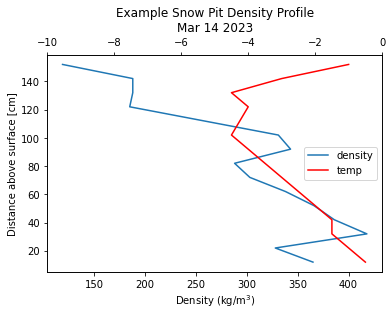

In [390]:

plt.plot(ds_data.sel(id='KP47').dropna(dim='depth').density,ds_data.sel(id='KP47').dropna(dim='depth').depth, label='density')
plt.plot([],[], color='r', label='temp')
plt.xlabel("Density (kg/m$^3$)")
plt.ylabel("Distance above surface [cm]")
plt.legend(loc='center right')
plt.twiny()
plt.plot(ds_data.sel(id='KP47').dropna(dim='depth').temperature,ds_data.sel(id='KP47').dropna(dim='depth').depth, color='r', label='temp')
plt.xlim(-10,0)
plt.ylabel("Temperature C")
plt.title("Example Snow Pit Density Profile\nMar 14 2023")

In [19]:
ds_data

<xarray.Dataset>
Dimensions:      (depth: 146, id: 48)
Coordinates:
  * depth        (depth) float64 0.0 2.0 3.0 4.0 5.0 ... 155.0 159.0 161.0 165.0
    time         (id) datetime64[ns] 2023-01-06T10:48:00 ... 2023-03-16T07:12:00
  * id           (id) <U4 'KP01' 'KP02' 'KP03' 'KP04' ... 'KP46' 'KP47' 'KP48'
Data variables:
    temperature  (id, depth) float64 -4.3 nan nan nan nan ... -2.6 nan nan -8.9
    density      (id, depth) float64 60.0 nan nan nan nan ... 152.0 nan nan 91.0
Attributes: (12/26)
    datetime:          2023-01-06 10:48:00
    depthUnits:        cm
    coordType:         lat_long
    elvUnits:          m
    pitNotes:          
    precip:            NO
    ...                ...
    useSymbols:        true
    first:             Daniel
    last:              Hogan
    name:              Daniel Hogan
    email:             dlhogan@uw.edu
    affil:             University of Washington

In [ ]:
### Compare bulk pit density with bulk density from snow pillows


### Compare temperature profiles with thermistors


### Compare surface temperatures


### Compare pillow snow depth with snow depth


### Plot snow depth over time

In [14]:
snow_depth=[]
for pit in ds_data.id:
    snow_depth.append(ds_data.sel(id=pit).temperature.dropna(dim='depth').depth[-1].values)

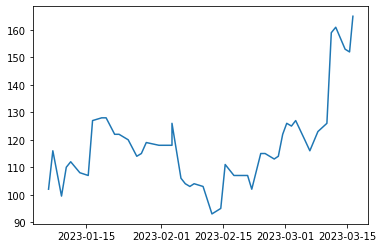

In [18]:
plt.plot(ds_data.time, snow_depth)